### Task 2

In [27]:
import logging
import pandas as pd
import os
import sys
import mlflow

sys.path.append(os.path.abspath('../scripts'))

from forecasting.arima_model import train_arima
from forecasting.sarima_model import train_sarima
from forecasting.lstm_model import preprocess_data, build_lstm, train_lstm
from forecasting.evaluation_metrics import evaluate_forecast
from utils.mlflow_utils import (
    start_mlflow_experiment, log_params, log_metrics, log_model, end_mlflow_experiment
)
import matplotlib.pyplot as plt

In [28]:
from utils.logging_config import setup_logger
setup_logger(log_file="task2_mlflow_forecasting.log", log_level=logging.INFO)

2024-11-17 15:24:08,152 - INFO - Logger initialized. Log file: logs\task2_mlflow_forecasting.log


In [29]:
logging.info("Task 2: Forecasting Pipeline with Multiple Datasets Started.")

2024-11-17 15:24:08,270 - INFO - Task 2: Forecasting Pipeline with Multiple Datasets Started.


In [30]:
datasets = {
    "TSLA": pd.read_csv("../data/processed/TSLA_processed.csv", parse_dates=["Date"], index_col="Date"),
    "SPY": pd.read_csv("../data/processed/SPY_processed.csv", parse_dates=["Date"], index_col="Date"),
    "BND": pd.read_csv("../data/processed/BND_processed.csv", parse_dates=["Date"], index_col="Date"),
}


In [32]:
import warnings
warnings.filterwarnings("ignore")

results = {}

for name, data in datasets.items():
    logging.info(f"Processing dataset: {name}")

    train = data['Adj Close'][:'2019']
    test = data['Adj Close']['2020':]

    arima_orders = {
        "TSLA": (0, 1, 1),
        "SPY": (3, 1, 1),
        "BND": (0, 1, 0)
    }

    with mlflow.start_run(nested=True, run_name=f"ARIMA_{name}"):
        logging.info(f"Training ARIMA for {name} with order {arima_orders[name]}...")
        
        arima_model = train_arima(train, order=arima_orders[name])
        
        arima_forecast = arima_model.forecast(steps=len(test))
        
        arima_metrics = evaluate_forecast(test.values, arima_forecast)
        
        log_params({"dataset": name, "model": "ARIMA", "order": arima_orders[name]})
        log_metrics(arima_metrics)
        log_model(arima_model, f"arima_model_{name}")

        results[name] = {"test": test, "arima_forecast": arima_forecast}

        logging.info(f"Completed processing for {name}. Metrics: {arima_metrics}")

2024-11-17 15:27:16,094 - INFO - Processing dataset: TSLA
2024-11-17 15:27:16,344 - INFO - Training ARIMA for TSLA with order (0, 1, 1)...
2024-11-17 15:27:16,345 - INFO - Starting ARIMA training with order (0, 1, 1).
2024-11-17 15:27:16,400 - INFO - ARIMA training completed with order (0, 1, 1).
2024/11/17 15:27:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024-11-17 15:27:20,411 - INFO - Logged model: arima_model_TSLA to MLflow.
2024-11-17 15:27:20,419 - INFO - Completed processing for TSLA. Metrics: {'MAE': np.float64(178.48832758615592), 'RMSE': np.float64(202.56084136042602)}
2024-11-17 15:27:20,423 - INFO - Processing dataset: SPY
2024-11-17 15:27:20,573 - INFO - Training ARIMA for SPY with order (3, 1, 1)...
2024-11-17 15:27:20,573 - INFO - Starting ARIMA training with order (3, 1, 1).
2024-11-17 15:27:20,873 - INFO - ARIMA training completed with

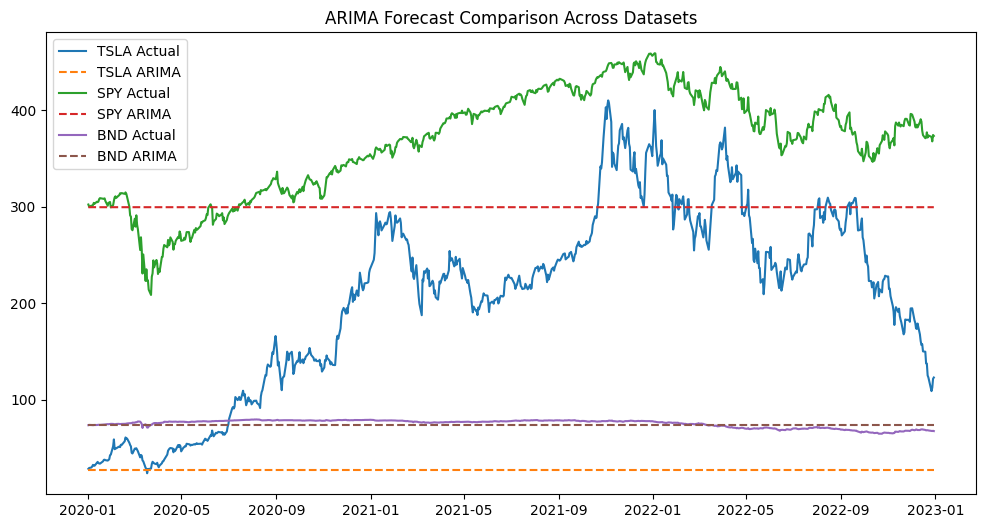

In [33]:
plt.figure(figsize=(12, 6))
for name, result in results.items():
    plt.plot(result["test"], label=f"{name} Actual", linestyle="solid")
    plt.plot(result["test"].index, result["arima_forecast"], label=f"{name} ARIMA", linestyle="--")
plt.legend()
plt.title("ARIMA Forecast Comparison Across Datasets")
plt.show()

In [34]:
plt.savefig("forecast_comparison.png")
mlflow.log_artifact("forecast_comparison.png")

<Figure size 640x480 with 0 Axes>